In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the general theme for the figures
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
sns.set_palette(palette = "hls", desat = 1)# n_colors = 3,

# Statistical Functions

In [2]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [3]:
def tukey(df, metric, fillna = 0):
    print("~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~")
    
    if fillna==False and type(fillna)==bool: df = df.dropna(subset = [metric])

    #perform one-way ANOVA
    anova = f_oneway(
        list(df[df["Condition"]=="OC"][metric].fillna(fillna)),
        list(df[df["Condition"]=="RC"][metric].fillna(fillna)),
        list(df[df["Condition"]=="HC"][metric].fillna(fillna))
    )

    print(anova)

    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=df[metric].fillna(fillna),
                            groups=df['Condition'],
                            alpha=0.05)

    print("~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~")

    # display results
    print(tukey)
   
    # compute the starts
    stars_boundaries = [5e-2, 1e-2, 1e-3, 1e-4]
    stars = ['*'*list(pair<=stars_boundaries).count(True) + " "*list(pair<=stars_boundaries).count(False) for pair in tukey.pvalues]
    
    print(tukey.pvalues)
    print(stars)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


In [4]:
def ttest(df, metric, equal_var=True ,fillna = 0):
    print("~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~")
    
    if fillna==False and type(fillna)==bool: df = df.dropna(subset = [metric])

    #perform one-way ANOVA
    anova = f_oneway(
        list(df[df["Condition"]=="OC"][metric].fillna(fillna)),
        list(df[df["Condition"]=="RC"][metric].fillna(fillna)),
        list(df[df["Condition"]=="HC"][metric].fillna(fillna))
    )

    print(anova)

    print("~~~~~~~~~~~~~~~~~~T-test~~~~~~~~~~~~~~~~~~~~")

    print(f'HC vs OC: {ttest_ind(list(df[df["Condition"]=="HC"][metric].fillna(fillna)),list(df[df["Condition"]=="OC"][metric].fillna(fillna))).pvalue:.5e}')
    print(f'HC vs RC: {ttest_ind(list(df[df["Condition"]=="HC"][metric].fillna(fillna)),list(df[df["Condition"]=="RC"][metric].fillna(fillna))).pvalue:.5e}')
    print(f'OC vs RC: {ttest_ind(list(df[df["Condition"]=="OC"][metric].fillna(fillna)),list(df[df["Condition"]=="RC"][metric].fillna(fillna))).pvalue:.5e}')
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# Load the Dataset

In [5]:
df = pd.read_csv('results.csv', index_col="Unnamed: 0")  # TODO eliminate all unused columns

# Perspective-Taking

## Confirms the results of the perspective-taken by the robot in the first task.

### Histogram of the time spent in the first perspective divided by the PT condition

Histogram

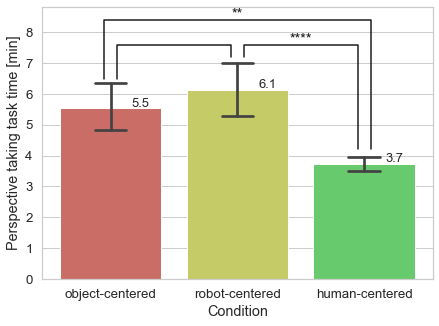

In [6]:
plt.figure(figsize=(7.0, 5.0))
g = sns.barplot(
    data=df.fillna(0).replace(["OC","HC","RC"], ["object-centered", "human-centered", "robot-centered"]),
    x="Condition",
    y="Perspective taking task time [min]",
    capsize = 0.25
)

# add significant values
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=13,
                   xytext = (30, 5), 
                   textcoords = 'offset points')

y1, y2, y3 = 6.5, 7.2, 4.2
h, col = 0.4, 'k'

plt.plot([-0.05, -0.05, 2.05, 2.05], [y1, y2+3*h, y2+3*h, y3], lw=1.5, c=col)
plt.text(1, y2+2.9*h, "**", ha='center', va='bottom', color=col)

plt.plot([0.05, 0.05, 0.95, 0.95], [y1, y2+h, y2+h, y2], lw=1.5, c=col)

plt.plot([1.05, 1.05, 1.95, 1.95], [y2, y2+h, y2+h, y3], lw=1.5, c=col)
plt.text(1.5, y2+0.9*h, "****", ha='center', va='bottom', color=col)

plt.savefig("figures/PT time histogram.pdf",bbox_inches='tight')

ANOVA and Tukey statistical tests on the time spent in the PT by each condition

In [7]:
tukey(df, "Perspective taking task time [min]")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=12.848477834962202, pvalue=1.9374816569309807e-05)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     OC   1.7983 0.0015  0.6155 2.9811   True
    HC     RC    2.404    0.0  1.2212 3.5867   True
    OC     RC   0.6057 0.4412 -0.5771 1.7884  False
---------------------------------------------------
[1.51074086e-03 2.13238315e-05 4.41190150e-01]
['**  ', '****', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Heat map: conditoin versus reverse condition

Create a CMAP from a discret pallet, highlightning the transition red -> yellow representing the small values. Why? Because in the heatmap, the total column has high values, and by increasing the contrast before in the continous scale, I'm adding more contrast in on the heatmap per se.

In [8]:
from matplotlib.colors import ListedColormap

colorarray = list(sns.hls_palette()[:3])
increment = [[colorarray[1][0]-colorarray[0][0], colorarray[1][1]-colorarray[0][1], colorarray[1][2]-colorarray[0][2]],[colorarray[2][0]-colorarray[1][0], colorarray[2][1]-colorarray[1][1], colorarray[2][2]-colorarray[1][2]]]
threshold = 30.0    # to control each increment is more significative in the continuous map
for i in range(98):
    if i < threshold: colorarray.insert(i+1,[colorarray[i][j]+increment[0][j]/threshold for j in range(3)]) # between red and yellow
    else: colorarray.insert(i+2,[colorarray[i+1][j]+increment[1][j]/(98-threshold) for j in range(3)]) # between yellow and green

cmap = ListedColormap(colorarray)

Heatmap

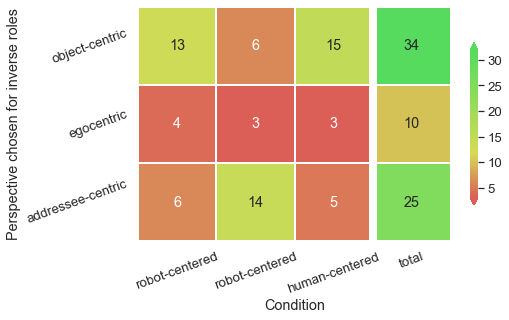

In [9]:
df_aux = df[["Condition", "If you were to tell the robot to pick up the objects how would you do it?"]].value_counts().copy()
df_heatmap = pd.DataFrame(columns=["Condition", "Perspective chosen for inverse roles", 'Occurrences'], dtype="float")
for condition_pair, occupance, in df_aux.iteritems():
    ideal_condition = "addressee-centric" if "your" in condition_pair[1] else "egocentric" if "my" in condition_pair[1] else "object-centric"
    df_heatmap = df_heatmap.append({
        "Condition": condition_pair[0],
        "Perspective chosen for inverse roles": ideal_condition,
        'Occurrences': occupance},
        ignore_index=True)

total = df_heatmap[["Perspective chosen for inverse roles", "Occurrences"]].groupby("Perspective chosen for inverse roles").sum().to_dict()["Occurrences"]
for key, value in total.items():
    df_heatmap = df_heatmap.append({
        "Condition": "total",
        "Perspective chosen for inverse roles": key,
        'Occurrences': value},
        ignore_index=True)

df_heatmap = df_heatmap.pivot("Perspective chosen for inverse roles", "Condition", "Occurrences")
# sorting
df_heatmap = df_heatmap[["OC", "RC", "HC","total"]]
df_heatmap = df_heatmap.reindex(["object-centric", "egocentric", "addressee-centric"])
df_heatmap.rename(columns = {"OC":"robot-centered", "RC": "robot-centered", "HC": "human-centered"}, inplace = True)

plt.figure(figsize=(7.0, 5.0))
ax = sns.heatmap(df_heatmap, annot=True, cmap = cmap, square="True", cbar_kws={"extend": "both", "shrink": 0.6}, robust=True, linewidths=0.05)
ax.axvline(3, color='white', lw=8)
plt.yticks(rotation=20)
plt.xticks(rotation=20)

plt.savefig(f"figures/Condition_chosen_for_inverse_roles.pdf",bbox_inches='tight')

Chi-square test on the Perspective chosen by condition

In [10]:

print(chi2_contingency(df_heatmap))
print(chi2_contingency(df_heatmap[["robot-centered", "robot-centered"]]))
print(chi2_contingency(df_heatmap[["human-centered", "robot-centered"]]))
print(chi2_contingency(df_heatmap[["human-centered", "robot-centered"]]))

(9.981176470588236, 0.12544696061875302, 6, array([[11.33333333, 11.33333333, 11.33333333, 34.        ],
       [ 3.33333333,  3.33333333,  3.33333333, 10.        ],
       [ 8.33333333,  8.33333333,  8.33333333, 25.        ]]))
(11.84360902255639, 0.06555002746520995, 6, array([[ 9.5,  9.5,  9.5,  9.5],
       [ 3.5,  3.5,  3.5,  3.5],
       [10. , 10. , 10. , 10. ]]))
(9.981176470588235, 0.04074595837884791, 4, array([[11.33333333, 11.33333333, 11.33333333],
       [ 3.33333333,  3.33333333,  3.33333333],
       [ 8.33333333,  8.33333333,  8.33333333]]))
(9.981176470588235, 0.04074595837884791, 4, array([[11.33333333, 11.33333333, 11.33333333],
       [ 3.33333333,  3.33333333,  3.33333333],
       [ 8.33333333,  8.33333333,  8.33333333]]))


## Personal Traits on answering the question: Do you think the manner the robot addressed the object influenced how much time you spent helping it?

ANOVA and tuukey tests on the answers to the question by group

In [11]:
tukey(df, "Do you think the manner the robot addressed the object influenced how much time you spent helping it?")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=5.848338540187446, pvalue=0.004588483518283926)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    HC     OC  -0.5217 0.6911 -2.0446  1.0011  False
    HC     RC   -2.087 0.0046 -3.6098 -0.5641   True
    OC     RC  -1.5652 0.0426 -3.0881 -0.0424   True
----------------------------------------------------
[0.69112822 0.00458748 0.04262308]
['    ', '**  ', '*   ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Perspective-Taking Scale

2D Inference

<Figure size 504x504 with 0 Axes>

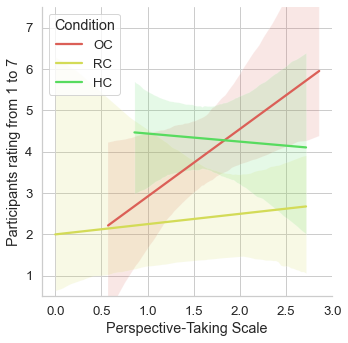

In [12]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Perspective-Taking Scale",
    y="Do you think the manner the robot addressed the object influenced how much time you spent helping it?",
    hue='Condition',
    data=df.fillna(1),
    robust=True,
    facet_kws = {"legend_out" : False},
    scatter=False
    )
g.set(ylabel="Participants rating from 1 to 7")
g.set(ylim=(0.5, 7.5))
plt.savefig(f"figures/PT scale on influence.pdf",bbox_inches='tight')

Statistical analyses

In [13]:
tukey(df, "Perspective-Taking Scale")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=0.252902535899786, pvalue=0.7772926391471243)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     OC  -0.0683 0.9195 -0.4878 0.3512  False
    HC     RC   0.0559 0.9453 -0.3636 0.4754  False
    OC     RC   0.1242 0.7585 -0.2953 0.5437  False
---------------------------------------------------
[0.91948481 0.94532911 0.75845142]
['    ', '    ', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Empathic Concern Scale

2D Inference

<Figure size 504x504 with 0 Axes>

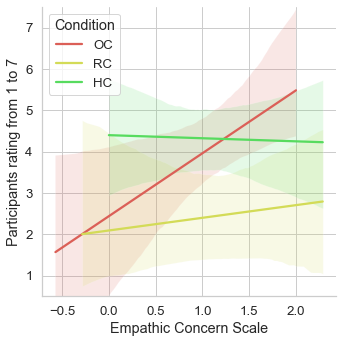

In [14]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Empathic Concern Scale",
    y="Do you think the manner the robot addressed the object influenced how much time you spent helping it?",
    hue='Condition',
    data=df.fillna(1),
    robust=True,
    facet_kws = {"legend_out" : False},
    scatter=False
    )
g.set(ylabel="Participants rating from 1 to 7")
g.set(ylim=(0.5, 7.5))
plt.savefig(f"figures/Empathic Concern scale on influence.pdf",bbox_inches='tight')

Statistical analyses

In [15]:
tukey(df, "Empathic Concern Scale")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=0.6112814224402205, pvalue=0.5456984253323292)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     OC  -0.2236 0.5225 -0.7147 0.2675  False
    HC     RC  -0.1429 0.7658 -0.6339 0.3482  False
    OC     RC   0.0807  0.918 -0.4103 0.5718  False
---------------------------------------------------
[0.52253608 0.76577588 0.91800627]
['    ', '    ', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Fantasy Scale

Statistical analyses

In [16]:
tukey(df, "Fantasy Scale")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=0.5942368587713747, pvalue=0.5549096517575077)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     OC   0.1677 0.6592  -0.293 0.6284  False
    HC     RC  -0.0248 0.9908 -0.4855 0.4359  False
    OC     RC  -0.1925 0.5782 -0.6532 0.2682  False
---------------------------------------------------
[0.65923946 0.99082605 0.57816151]
['    ', '    ', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Prosocial Behavior

## Analysis of the number of sentences read

### Prosocial Behavior metrics correlation

In [17]:
df[["Number of sentences read", "Prosocial behaviour time [min]", "Sentences read prior guess"]].fillna(0).corr()

,Number of sentences read,Prosocial behaviour time [min],Sentences read prior guess
Number of sentences read,1.000000,0.900477,0.728879
Prosocial behaviour time [min],0.900477,1.000000,0.683100
Sentences read prior guess,0.728879,0.683100,1.000000


In [18]:
pd.crosstab(df["Condition"], df["Did you read sentences to the robot?"])

Did you read sentences to the robot?,No,Yes
Condition,,
HC,0,23
OC,3,20
RC,10,13


In [19]:
x = chi2_contingency(pd.crosstab(df[df["Condition"]!="HC"]["Condition"], df["Did you read sentences to the robot?"]))
print(f"Chi-square test between RC and OC: Chi = {x[0]:.3f}\;p={x[1]:.3e}\;df={x[2]}")
x = chi2_contingency(pd.crosstab(df[df["Condition"]!="RC"]["Condition"], df["Did you read sentences to the robot?"]))
print(f"Chi-square test between HC and OC: Chi = {x[0]:.3f}\;p={x[1]:.3e}\;df={x[2]}")
chi2_contingency(pd.crosstab(df["Condition"], df["Did you read sentences to the robot?"]))

Chi-square test between RC and OC: Chi = 3.860\;p=4.945e-02\;df=1
Chi-square test between HC and OC: Chi = 1.426\;p=2.324e-01\;df=1


(14.975274725274726,
 0.0005599643916268729,
 2,
 array([[ 4.33333333, 18.66666667],
        [ 4.33333333, 18.66666667],
        [ 4.33333333, 18.66666667]]))

### Histogram of the sentences read by group

Histogram

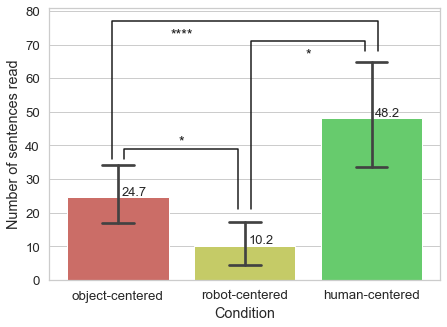

In [20]:
plt.figure(figsize=(7.0, 5.0))
g = sns.barplot(
    data=df.fillna(0).replace(["OC","HC","RC"], ["object-centered", "human-centered", "robot-centered"]),
    x="Condition",
    y="Number of sentences read",
    capsize = 0.25
)

# add significant values
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=13,
                   xytext = (16, 5), 
                   textcoords = 'offset points')

y1, y2, y3 = 36, 21, 68
h, col = 3, 'k'

plt.plot([-0.05, -0.05, 2.05, 2.05], [y1, y3+3*h, y3+3*h, y3], lw=1.5, c=col)
plt.text(0.5, y3+h, "****", ha='center', va='bottom', color=col)

plt.plot([0.05, 0.05, 0.95, 0.95], [y1, y1+h, y1+h, y2], lw=1.5, c=col)
plt.text(0.5, y1+h, "*", ha='center', va='bottom', color=col)

plt.plot([1.05, 1.05, 1.95, 1.95], [y2, y3+h, y3+h, y3], lw=1.5, c=col)
plt.text(1.5, y3-h, "*", ha='center', va='bottom', color=col)

plt.savefig("figures/PT time on sentences read histogram.pdf",bbox_inches='tight')  

Statistical Analyses

In [21]:
ttest(df, "Number of sentences read")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=11.02688981888106, pvalue=7.383559724802273e-05)
~~~~~~~~~~~~~~~~~~T-test~~~~~~~~~~~~~~~~~~~~
HC vs OC: 1.55511e-02
HC vs RC: 1.13675e-04
OC vs RC: 1.45968e-02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Inference of the time spent on the PT task on the sentences read

2D Inference

<Figure size 504x504 with 0 Axes>

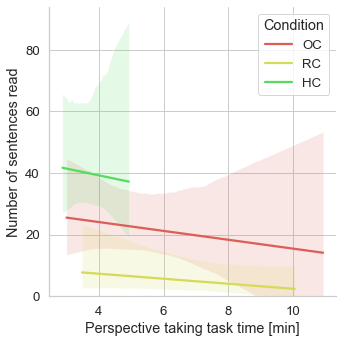

In [22]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Perspective taking task time [min]",
    y="Number of sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False},
    scatter=False
    )
g.set(ylim=(0, None))

plt.savefig(f"figures/PT time on sentences read.pdf",bbox_inches='tight')

In [23]:
df[["Number of sentences read", "Prosocial behaviour time [min]", "Sentences read prior guess","Perspective taking task time [min]"]].fillna(0).corr()

,Number of sentences read,Prosocial behaviour time [min],Sentences read prior guess,Perspective taking task time [min]
Number of sentences read,1.000000,0.900477,0.728879,-0.336021
Prosocial behaviour time [min],0.900477,1.000000,0.683100,-0.275711
Sentences read prior guess,0.728879,0.683100,1.000000,-0.406511
Perspective taking task time [min],-0.336021,-0.275711,-0.406511,1.000000


## Possible confounding effects caused by different perspective on reading sentences

### Difficulty on following the instructions

2D Inference

<Figure size 504x504 with 0 Axes>

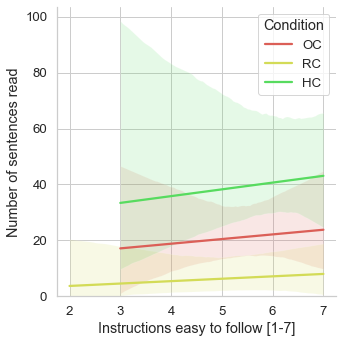

In [24]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Instructions easy to follow [1-7]",
    y="Number of sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False},
    scatter=False
    )
g.set(ylim=(0, None))
plt.savefig(f"figures/Instruction difficulty on sentences read.pdf",bbox_inches='tight')

Statistical analyses

In [25]:
tukey(df, "Instructions easy to follow [1-7]")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=3.5184757505773656, pvalue=0.03532179978409998)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    HC     OC  -0.3043 0.6006 -1.0596  0.4509  False
    HC     RC  -0.8261 0.0288 -1.5813 -0.0708   True
    OC     RC  -0.5217 0.2297  -1.277  0.2335  False
----------------------------------------------------
[0.60064749 0.02879122 0.22968786]
['    ', '*   ', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Need the robot for collecting speech data

2D Inference

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/robust/robust_linear_model.py:290: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)


<Figure size 504x504 with 0 Axes>

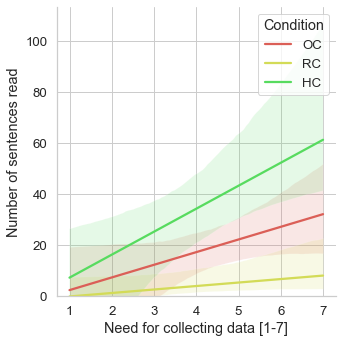

In [26]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Need for collecting data [1-7]",
    y="Number of sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False},
    scatter=False
    )
g.set(ylim=(0, None))
plt.savefig(f"figures/Need data on sentences read.pdf",bbox_inches='tight')

Statistical analyses

In [27]:
tukey(df, "Need for collecting data [1-7]")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=0.5731357552581262, pvalue=0.56653546189198)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     OC   0.2174 0.8972 -0.9564 1.3912  False
    HC     RC  -0.3043 0.8088 -1.4782 0.8695  False
    OC     RC  -0.5217 0.5386 -1.6956 0.6521  False
---------------------------------------------------
[0.89719148 0.80879299 0.53856963]
['    ', '    ', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [28]:
df[["Number of sentences read", "Need for collecting data [1-7]"]].fillna(0).corr()

,Number of sentences read,Need for collecting data [1-7]
Number of sentences read,1.00000,0.33004
Need for collecting data [1-7],0.33004,1.00000


# Numerical Analysis

Setences read per each condition

In [29]:
df[["Condition", "Number of sentences read"]].fillna(0).groupby("Condition")["Number of sentences read"].mean()

Condition
HC    48.173913
OC    24.695652
RC    10.217391
Name: Number of sentences read, dtype: float64

# Extras

In [30]:
from pingouin import mediation_analysis, read_dataset

In [31]:
df_aux = df[df["Condition"]!="HC"][["Condition", "Total scanning time [min]", "Number of sentences read"]].fillna(0).copy()
df_aux["Condition"] = df_aux["Condition"].replace(["RC", "OC"], [1, 0])
mediation_analysis(data=df_aux.fillna(0), x='Condition', m='Total scanning time [min]', y='Number of sentences read')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Total scanning time [min] ~ X,0.372196,0.309561,0.235664,-0.251683,0.996074,No
1,Y ~ Total scanning time [min],-3.182997,2.882554,0.275497,-8.992403,2.626409,No
2,Total,-14.478261,5.694249,0.014597,-25.954266,-3.002256,Yes
3,Direct,-13.730321,5.818902,0.022904,-25.465255,-1.995387,Yes
4,Indirect,-0.747940,1.380863,0.524000,-5.214075,0.618007,No


In [32]:
df_aux = df[df["Condition"]!="RC"][["Condition", "Total scanning time [min]", "Number of sentences read"]].fillna(0).copy()
df_aux["Condition"] = df_aux["Condition"].replace(["HC", "OC"], [0, 1])
mediation_analysis(data=df_aux.fillna(0), x='Condition', m='Total scanning time [min]', y='Number of sentences read')

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Total scanning time [min] ~ X,0.939217,0.220361,0.000105,0.495110,1.383325,Yes
1,Y ~ Total scanning time [min],-8.532247,5.596173,0.134501,-19.810593,2.746098,No
2,Total,-23.478261,9.327609,0.015551,-42.276822,-4.679699,Yes
3,Direct,-21.849475,11.205944,0.057739,-44.448416,0.749466,No
4,Indirect,-1.628786,4.532299,0.692000,-11.660133,7.462425,No


In [33]:
df_aux = df[df["Condition"]!="OC"][["Condition", "Total scanning time [min]", "Number of sentences read"]].fillna(0).copy()
df_aux["Condition"] = df_aux["Condition"].replace(["RC", "HC"], [0, 1])
mediation_analysis(data=df_aux.fillna(0), x='Condition', m='Total scanning time [min]', y='Number of sentences read')

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Total scanning time [min] ~ X,-1.311413,0.235956,0.000002,-1.786951,-0.835875,Yes
1,Y ~ Total scanning time [min],-12.871138,4.829951,0.010727,-22.605265,-3.137012,Yes
2,Total,37.956522,8.956771,0.000114,19.905336,56.007708,Yes
3,Direct,35.874255,11.809973,0.004043,12.057175,59.691335,Yes
4,Indirect,2.082266,3.657934,0.464000,-4.481114,9.379596,No


In [34]:
tukey(df, "Caring [1-7]")

~~~~~~~~~~~~~~~one way ANOVA~~~~~~~~~~~~~~~
F_onewayResult(statistic=3.319843978547051, pvalue=0.042287193837986056)
~~~~~~~~~~~~~~~~Tukey test~~~~~~~~~~~~~~~~~
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    HC     OC  -0.2174 0.8953 -1.3797  0.9449  False
    HC     RC  -1.1739 0.0472 -2.3362 -0.0116   True
    OC     RC  -0.9565 0.1269 -2.1188  0.2058  False
----------------------------------------------------
[0.89525198 0.0472266  0.12688014]
['    ', '*   ', '    ']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [35]:
df.columns

Index(['Condition', 'Help Q1', 'Help Q10', 'Help Q11', 'Help Q12', 'Help Q13',
       'Help Q14', 'Help Q15', 'Help Q2', 'Help Q3', 'Help Q4', 'Help Q5',
       'Help Q6', 'Help Q7', 'Help Q8', 'Help Q9', 'Mental Model Q1',
       'Mental Model Q15', 'Mental Model Q8', 'Mistakes Q1', 'Mistakes Q10',
       'Mistakes Q11', 'Mistakes Q12', 'Mistakes Q13', 'Mistakes Q14',
       'Mistakes Q15', 'Mistakes Q2', 'Mistakes Q3', 'Mistakes Q4',
       'Mistakes Q5', 'Mistakes Q6', 'Mistakes Q7', 'Mistakes Q8',
       'Mistakes Q9', 'Perspective taking task time [min]', 'Time Q1',
       'Time Q10', 'Time Q11', 'Time Q12', 'Time Q13', 'Time Q14', 'Time Q15',
       'Time Q2', 'Time Q3', 'Time Q4', 'Time Q5', 'Time Q6', 'Time Q7',
       'Time Q8', 'Time Q9', 'Tries Q1', 'Tries Q10', 'Tries Q11', 'Tries Q12',
       'Tries Q13', 'Tries Q14', 'Tries Q15', 'Tries Q2', 'Tries Q3',
       'Tries Q4', 'Tries Q5', 'Tries Q6', 'Tries Q7', 'Tries Q8', 'Tries Q9',
       'Number of sentences read', 'Sente

In [36]:
print("Done running")

Done running
